In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler,RobustScaler
import matplotlib.pyplot as plt
from datetime import date

In [4]:
# Step 1: Fetch USD/CAD Data from yfinance
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
def get_usdcad_data():
    ticker = "BTC-USD"  # USD/CAD exchange rate
    data = yf.download(ticker, start=START, end=TODAY)
    data.to_csv('xau_usd.csv')
    data = data[['Close']]  # Use the 'Close' price for prediction
    return data


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler


In [6]:
def preprocess_data(data, sequence_length):
    # First scale using RobustScaler to reduce outlier influence
    robust_scaler = RobustScaler()
    data_robust = robust_scaler.fit_transform(data)
    
    # Then standardize using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_robust)
    
    # Prepare sequences for prediction
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, robust_scaler


In [7]:
def predict_future(model, input_data, scaler, robust_scaler, future_steps=10):
    predicted_values = []
    # Start with the last sequence in the input data
    current_sequence = input_data[-1].reshape(1, input_data.shape[1], input_data.shape[2])

    for _ in range(future_steps):
        next_value = model.predict(current_sequence)  # Predict next value
        predicted_values.append(next_value[0])         # Save predicted value
        
        # Update current_sequence by appending the prediction and dropping the oldest entry
        next_value_reshaped = next_value.reshape((1, 1, input_data.shape[2]))
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_value_reshaped), axis=1)

    # Convert predictions back to original scale by inverting both scalers in reverse order:
    # 1. Invert StandardScaler, then 2. Invert RobustScaler.
    predicted_values = np.array(predicted_values)
    predicted_values_inversed = robust_scaler.inverse_transform(scaler.inverse_transform(predicted_values))

    # Adjust predictions so that the first prediction attaches to the last real price
    # First, obtain the last known price in the original scale:
    last_sequence_inversed = robust_scaler.inverse_transform(scaler.inverse_transform(input_data[-1]))
    last_real_price = last_sequence_inversed[-1]
    
    # Compute the offset between the last real price and the first prediction
    prediction_offset = last_real_price - predicted_values_inversed[0]
    predicted_values_original = predicted_values_inversed + prediction_offset

    return predicted_values_original


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data Loaded
Data Preprocessed
Model Loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

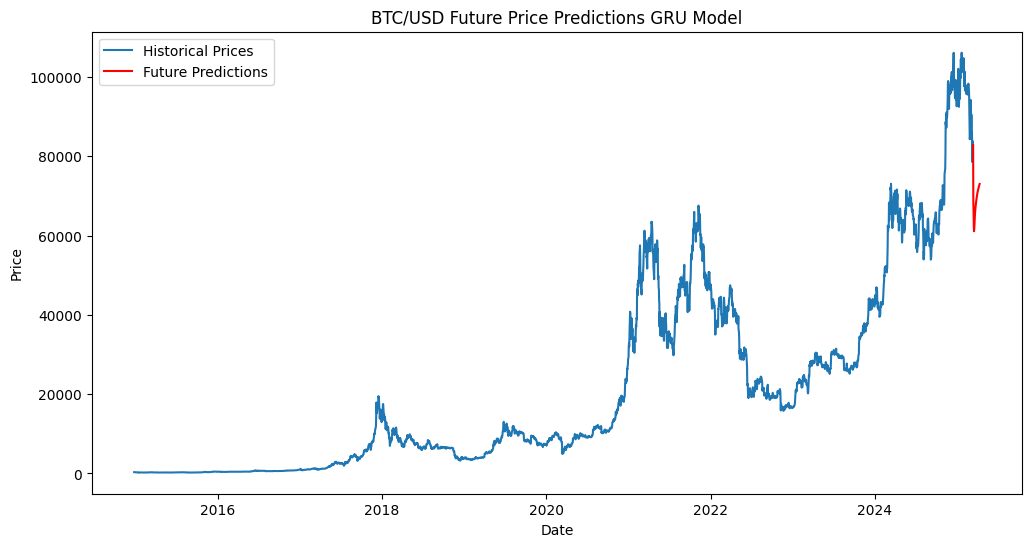

In [8]:
if __name__ == "__main__":
    # Step 1: Load Data (choose either get_usdcad_data() or get_xauusd_data())
    data = get_usdcad_data()  
    print("Data Loaded")
    
    # Step 2: Preprocess Data
    sequence_length = 100  # Adjust as needed
    X, y, scaler, robust_scaler = preprocess_data(data, sequence_length)
    print("Data Preprocessed")
    
    # Step 3: Load Trained Model
    model_path = "./models/gru_model.keras"  # Path to your saved model
    model = load_model(model_path)
    print("Model Loaded")
    
    # Step 4: Predict Future Values
    future_steps = 30 # Number of future time steps to predict
    future_predictions = predict_future(model, X, scaler, robust_scaler, future_steps)
    print("Future Predictions:", future_predictions.flatten())
    
    # Step 5: Visualization
    plt.figure(figsize=(12, 6))
    
    # Invert both scalers for historical y-values to get original prices
    historical_prices = robust_scaler.inverse_transform(scaler.inverse_transform(y))
    plt.plot(data.index[-len(y):], historical_prices, label="Historical Prices")
    
    # Create a date range for the future predictions, starting right after the last available date
    future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='D')[1:]
    plt.plot(future_index, future_predictions, label="Future Predictions", color="red")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("BTC/USD Future Price Predictions GRU Model")
    plt.legend()
    plt.show()


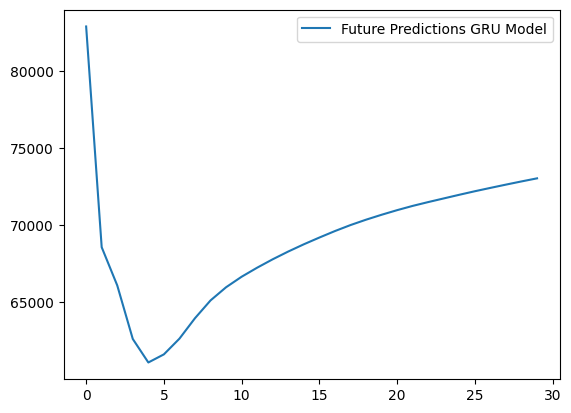

In [9]:
plt.plot(future_predictions, label="Future Predictions GRU Model")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Data Loaded
Data Preprocessed
Model Loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

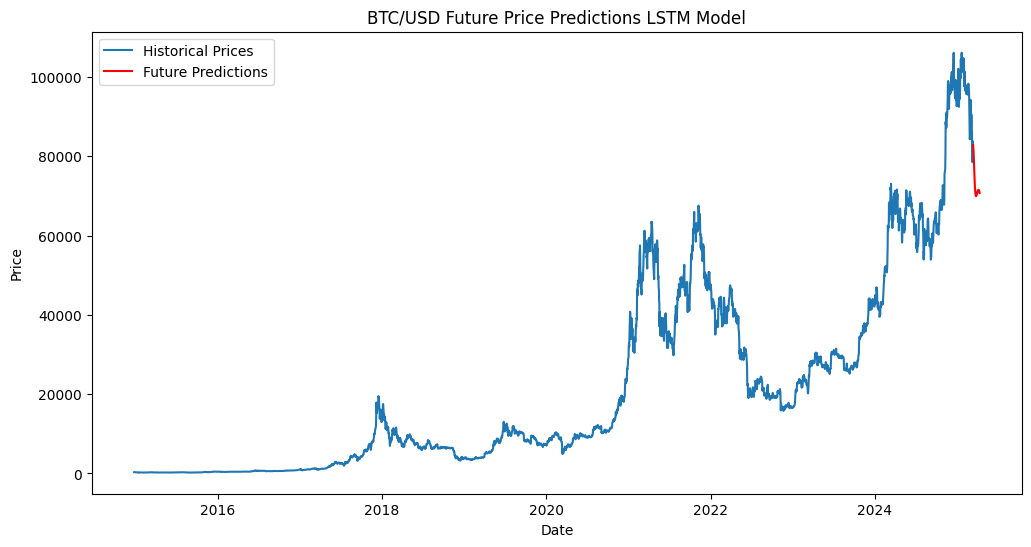

In [10]:
if __name__ == "__main__":
    # Step 1: Load Data (choose either get_usdcad_data() or get_xauusd_data())
    data = get_usdcad_data()  
    print("Data Loaded")
    
    # Step 2: Preprocess Data
    sequence_length = 100  # Adjust as needed
    X, y, scaler, robust_scaler = preprocess_data(data, sequence_length)
    print("Data Preprocessed")
    
    # Step 3: Load Trained Model
    model_path = "./models/lstm_model.keras"  # Path to your saved model
    model = load_model(model_path)
    print("Model Loaded")
    
    # Step 4: Predict Future Values
    future_steps = 30 # Number of future time steps to predict
    future_predictions = predict_future(model, X, scaler, robust_scaler, future_steps)
    print("Future Predictions:", future_predictions.flatten())
    
    # Step 5: Visualization
    plt.figure(figsize=(12, 6))
    
    # Invert both scalers for historical y-values to get original prices
    historical_prices = robust_scaler.inverse_transform(scaler.inverse_transform(y))
    plt.plot(data.index[-len(y):], historical_prices, label="Historical Prices")
    
    # Create a date range for the future predictions, starting right after the last available date
    future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='D')[1:]
    plt.plot(future_index, future_predictions, label="Future Predictions", color="red")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("BTC/USD Future Price Predictions LSTM Model")
    plt.legend()
    plt.show()


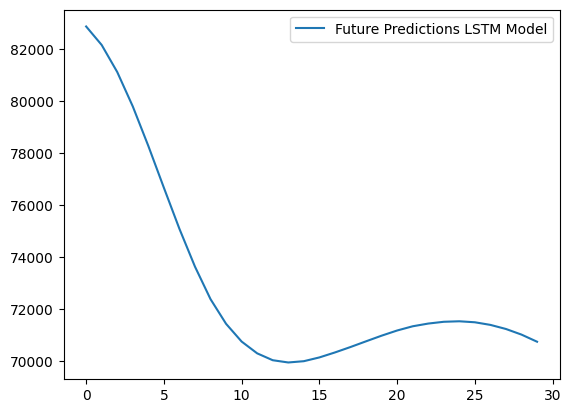

In [11]:
plt.plot(future_predictions, label="Future Predictions LSTM Model")
plt.legend()
plt.show()

In [12]:
from tensorflow.keras.models import load_model
lstm_model_path = "./ensembling/lstm_model.keras"  # Path to your saved model
gru_model_path  = "./ensembling/gru_model.keras"
lstm_model = load_model(lstm_model_path)
gru_model = load_model(gru_model_path)
print("Models Loaded Successfully!")

Models Loaded Successfully!


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


In [14]:
def predict_future(lstm_model, gru_model, meta_model, input_data, scaler, robust_scaler, future_steps):
    predicted_values = []
    
    # Get the last known sequence from input data
    current_sequence = input_data[-1].reshape(1, input_data.shape[1], input_data.shape[2])  

    for _ in range(future_steps):
        # Get predictions from LSTM & GRU
        lstm_pred = lstm_model.predict(current_sequence)  # Shape: (1, 1)
        gru_pred = gru_model.predict(current_sequence)    # Shape: (1, 1)
        
        # Stack the predictions as features for meta-model
        stacked_input = np.column_stack((lstm_pred, gru_pred))  # Shape: (1, 2)
        
        # Predict final price using the meta-model
        next_value = meta_model.predict(stacked_input)  # Shape: (1, 1)
        predicted_values.append(next_value[0, 0])  # Store prediction
        
        # Update the input sequence: drop the first time step and add the new prediction
        next_input = np.append(current_sequence[:, 1:, :], [[[next_value[0, 0]]]], axis=1)
        current_sequence = next_input

    # Convert predictions back to original scale by inverting both scalers
    predicted_values = np.array(predicted_values).reshape(-1, 1)  # Reshape for scaler
    predicted_values_inversed = robust_scaler.inverse_transform(scaler.inverse_transform(predicted_values))

    # Adjust predictions to continue smoothly from last real price
    last_sequence_inversed = robust_scaler.inverse_transform(scaler.inverse_transform(input_data[-1]))
    last_real_price = last_sequence_inversed[-1]
    
    # Compute offset to align predictions
    prediction_offset = last_real_price - predicted_values_inversed[0]
    predicted_values_original = predicted_values_inversed + prediction_offset

    return predicted_values_original.flatten()  # Return as 1D array


In [15]:

if __name__ == "__main__":
    # Step 1: Load Data
    data = get_usdcad_data()  # Use get_xauusd_data() if needed
    print("Data Loaded")
    
    # Step 2: Preprocess Data
    sequence_length = 100  # Adjust as needed
    X, y, scaler, robust_scaler = preprocess_data(data, sequence_length)
    print("Data Preprocessed")
    
    # Step 3: Load Trained Models
    lstm_model = load_model("./ensembling/lstm_model.keras")  # Load LSTM model
    gru_model = load_model("./ensembling/gru_model.keras")    # Load GRU model
    meta_model = load_model("./ensembling/final_mlp_model.keras")  # Load final ensemble model
    print("Models Loaded")
    
    # Step 4: Predict Future Values
    future_steps = 40  # Number of future time steps to predict
    future_predictions = predict_future(lstm_model, gru_model, meta_model, X, scaler, robust_scaler, future_steps)
    print("Future Predictions:", future_predictions.flatten())
    


[*********************100%***********************]  1 of 1 completed

Data Loaded


Data Preprocessed
Models Loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━

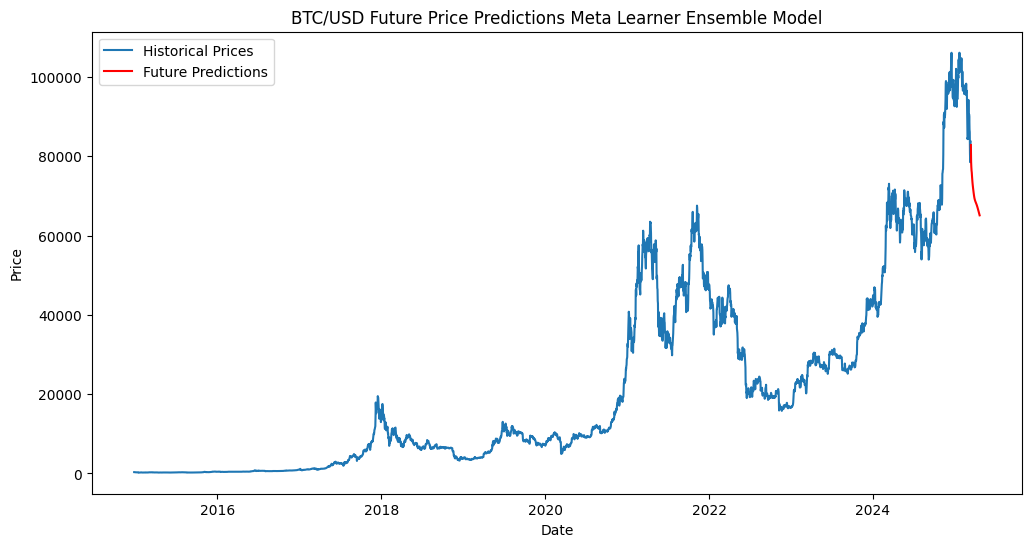

In [16]:
# Step 5: Visualization
plt.figure(figsize=(12, 6))

# Invert scalers to get original price values
historical_prices = robust_scaler.inverse_transform(scaler.inverse_transform(y))
plt.plot(data.index[-len(y):], historical_prices, label="Historical Prices")

# Create a future date range
future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='D')[1:]
plt.plot(future_index, future_predictions, label="Future Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BTC/USD Future Price Predictions Meta Learner Ensemble Model")
plt.legend()
plt.show()


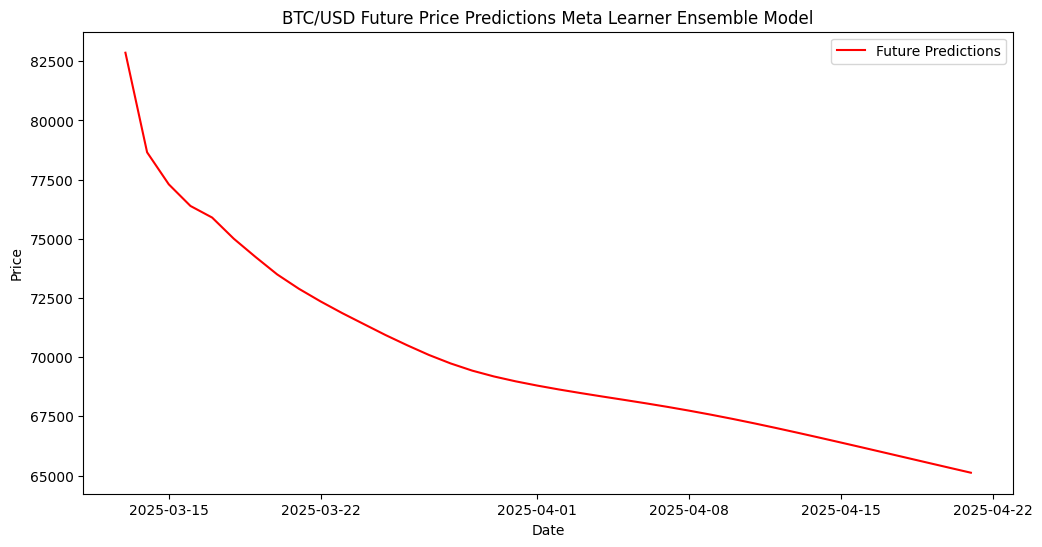

In [17]:
# Step 5: Visualization
plt.figure(figsize=(12, 6))

# Create a future date range
future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='D')[1:]
plt.plot(future_index, future_predictions, label="Future Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BTC/USD Future Price Predictions Meta Learner Ensemble Model")
plt.legend()
plt.show()